# Final Report

Contributors: Amy Phung and Kyle Bertram

## Overview
The approach we used to levitate the magnet can be summarized as follows:
- We used a PD controller
- To force "unity feedback," we used the output of our sensor model as input to our system
- To help account for disturbances (gravity) in our controller, we added an offset voltage to center our output around the voltage value that would theoretically offset gravity perfectly

Here's a block diagram that describes our approach:

<img src="./images/block-diagram.PNG" width="70%">

where :
- $y$ = distance setpoint
- $C$ = controller block
- $D$ = disturbance, representing gravity
- $G_c$ = circuit "plant" (models inductance)
- $G_e$ = electromagnet "plant" (models physical effect of electromagnet on permanent magent's position)
- $\hat{y}$ = measured distance

To make our system have "unity feedback," we used the estimated position output of our hall sensor model as feedback to "close the loop" in our system instead of using the hall voltage directly.

To see a video of our controller in action, visit: https://photos.app.goo.gl/DcuAdg23ufpoWhGv5

In [1]:
%matplotlib inline
# %matplotlib widget

# Import external modules
import time
from matplotlib import pyplot as plt
from IPython.display import HTML
import numpy as np
import math
from scipy.optimize import curve_fit

# Import the system module.
import mag_lev

In [2]:
# Format Plots
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.dpi'] = 150

# Change font
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

Here are the constants we used for our model. We will explain their derivation below

In [3]:
MAX_VOLTAGE = 7.0                   # [V]
R = 2.41                             # Coil Resistance [ohms]
L = 0.015266817305695372             # Inductance [H]
c_I_to_V_h = 0.47996355000000007     # Computed scaling constant between electromagnet current and hall voltage

# Lumped parameter constants for V_h to position
hall_params = [2.58897620e-05, 2.49441669e+00, 1.35761509e-02]

# Lumped paramter in electromagnet current to position model
C1 = -0.0000025 

# For computing hall voltage contribution from magnet
C2 = 0.86 # Electromagnet voltage scaling
C3 = 0.39 # Distance derivative scaling

# Linearization setpoints
m = 0.0031880407975657618  # Permanent magnet mass [kg]
I_bar = 1.5 # Note: magnet will be pre-charged to this value
y_bar = 0.025 # Note: this is the point where we will try to control around
V_e_bar = I_bar * R # Theoretical voltage needed to create I_bar

-----------


## Modeling


#### $G_c$ Model

Since the circuit's relationship between current and voltage can be modeled as a linear system whose transfer function can be written as 

$$\frac{I}{V} = \frac{1}{R + Ls}$$

We can compute the inductance by observing the electromagnet's time constant, which can be measured using the hall effect sensor (we can do this if we assume that the hall effect sensor's dynamics are negligible)

For a first order system of the form 
$$\frac{k}{\tau s + 1}$$

$\tau$ represents the time constant. With this information, we can conclude that the time constant of our system should be 
$$\tau = \frac{L}{R}$$


To start, let's take some measurements of $V_h$ when the PWM is set to $100$

In [7]:
sys_3 = mag_lev.MagLev()
sys_3.start_system()
sys_3.set_max_coil_voltage_magnitude(MAX_VOLTAGE)

time_list = []
V_h_list = []

sys_3.remove_magnet()
time.sleep(1)

start_t = time.time()

# The delay is added to ensure we can directly observe the point at which the 
# electromagnet is turned on
delay = 0.1
test_PWM = 100

while (time.time() - start_t < 0.2):        
    if time.time() - start_t > delay: # Add in delay to ensure we actually start from '0'
        sys_3.set_amplifier_input(test_PWM, sys_3.FORWARD)
    time_list.append(time.time() - start_t)
    V_h_list.append(sys_3.get_hall_voltage())
    
sys_3.stop_system()

Starting system...
System started
You cannot remove a magnet that is not present.
System stopped


Since there's some distance between the measurements, let's extrapolate between the points with a best-fit line

We know that the time-domain response can be written as
$$
V_h = (V_{max} - V_{min})(1-e^{-t/\tau}) + V_{min}
$$

where 
- $V_{max}$ is the steady-state hall voltage for a given PWM command
- $V_{min}$ is the hall voltage when the PWM = $0$
- $\tau$ is the time constant, which is equal to $\frac{L}{R}$

Inverting this function gives us 
$$
-\tau \ln{(- \frac{V_h-V_{min}}{V_{max}-V_{min}} + 1)} = t
$$
which allows us to compute what the time constant is given the expected value for the hall voltage

In [8]:
V_max = max(V_h_list)
V_min = min(V_h_list)

time_list = np.array(time_list)
V_h_list = np.array(V_h_list)

# Get index of point closest to t=0.1 (delay)
# Compute differences
deltas = abs(time_list - delay) 

# Get closest index
idx = np.argmin(deltas)

# Only use data from t > 0.1
idx = idx

In [9]:
calibration_t = time_list[idx:] - delay
calibration_V_h = V_h_list[idx:]

def hallFuncPWM100(t, L):
    return (V_max - V_min)*(1-math.e**(-t*R/L)) + V_min

def inverseHallFuncPWM100(V_h, L):
    return -L/R * math.log(-(V_h - V_min)/(V_max - V_min) + 1)

In [10]:
# Only use points after t=0.1 for curve fitting
V_h_model, pcov = curve_fit(hallFuncPWM100, calibration_t, calibration_V_h)

# Expected value of V_h at time constant
V_h_tc = (1- 1/math.e) * (V_max - V_min) + V_min 

# Compute time constant
tc = inverseHallFuncPWM100(V_h_tc, V_h_model)

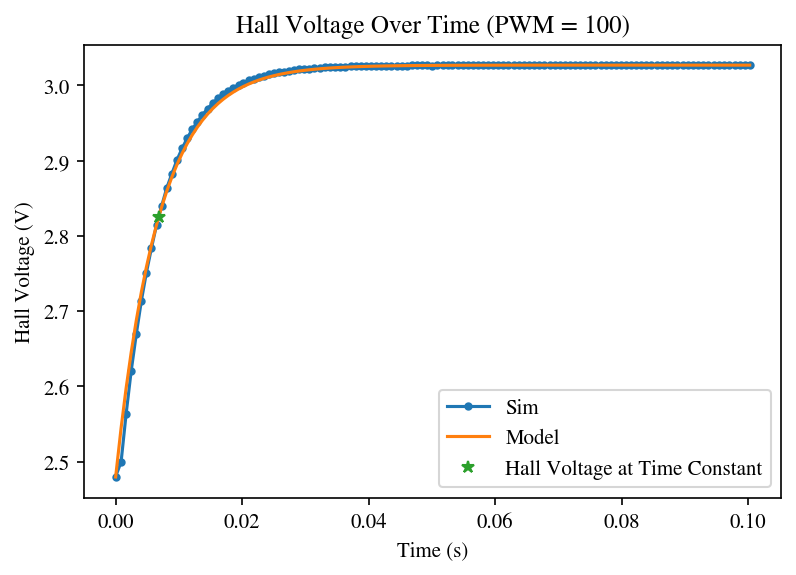

In [12]:
plt.plot(calibration_t, calibration_V_h, '.-', label="Sim")
plt.plot(calibration_t, hallFuncPWM100(calibration_t, *V_h_model), label="Model")
plt.plot(tc, V_h_tc, '*', label="Hall Voltage at Time Constant")
plt.title("Hall Voltage Over Time (PWM = 100)")
plt.ylabel("Hall Voltage (V)")
plt.xlabel("Time (s)")
plt.legend()

We can use $\tau$ to compute the inductance since $\tau =\frac{L}{R}$

In [14]:
R * tc

array([0.0164527])

#### $G_e$ Model

Since we're defining $y$ to be distance, the electromagnet's effect on $y$ will be in the negative direction (since it pulls the magnet closer), and gravity's effect will be in the positive direction (since it pulls the magnets apart). The ODE we're using to model this relationship can be written as:

$$m \frac{d^2 y}{dt^2} = m g - \frac{\mu_0 N I A m_2}{L 4 \pi y^2}$$

where:
- $m$ = mass
- $y$ = distance 
- $g$ = gravitational constant, 9.81
- $\mu_0$ = the magnetic constant
- $I$ = electromagnet current
- $N$ = number of turns in electromagnet coil
- $A$ = cross-sectional area of magnet wire
- $m_2$ = magnetic dipole moment for permanent magnet
- $L$ = length of the magnet

Since a lot of these constants are difficult to aquire individually, we condensed them all into the constant $C_1$ and re-wrote this equation as follows:

$$\frac{d^2 y}{dt^2} = g - \frac{C_1 I}{4 \pi y^2}$$

We hand-adjusted $C_1$ by comparing our model implementation and the simulation results side-by-side

#### Measurement Model
In order to simplify the controller for our system, we decided to model the hall effect sensor for our system separately so that we could use its position estimate as feedback for our controller. Using the computed position value instead of the raw hall voltage as feedback allows our control loop to have unity feedback since we have direct feedback of the parameter we want to control 

To do this, we needed a function that maps directly from the hall voltage $V_h$ to magnet distance $y$. However, we found that this relationship is also dependent on additional variables such as the electromagnet current and permanent magnet velocity, which we needed to account for in our function.

Through testing, we found that each shift in 50 PWM (at steady state when max voltage is set to 10V) is pretty strongly correlated with a hall voltage shift of 0.3905. We used this relationship to compute `c_I_to_V_h` 

In [18]:
PWM_delta = 50

# Compute electromagnet voltage
V_e_delta = PWM_delta/255 * 10

# Compute steady-state current 
I_delta = V_e_delta / R

# Compute scaling constant
c_I_to_V_h = 0.3905 / I_delta

c_I_to_V_h

0.47996355000000007

Now that we have a scaling constant that computes the electromagnet's contribution to the hall voltage, we can create a function that allows the hall effect sensor to act like a position sensor

We know that the magnet's B field is directly proportional to the hall effect sensor's voltage (once the electromagnet's effects are removed), so let's start with the equation for a permanent magnet B field 
$$
\mathbf{B}(\mathbf{r}) = 
    \frac{\mu_0}{4 \pi} 
    \frac{3 \mathbf{\hat{r}} (\mathbf{\hat{r}} \cdot \mathbf{m}) - \mathbf{m}}{|r|^3}
$$
(This equation models the magnet as a magnetic dipole moment, which doesn’t consider the shape of the magnet at all. We assume that $\hat{r}$ is perpendicular to the magnetic dipole moment $m$) 

Reference: https://en.wikipedia.org/wiki/Magnetic_moment#Magnetic_pole_model

If we assume $\mathbf{m}$ is a constant and that we have the magnetic field perfectly aligned, we can separate all of the constants out as follows:

$$
\mathbf{B}(\mathbf{r}) = 
    \frac{\mu_0 (2\mathbf{m})}{4 \pi} 
    \frac{1}{|r|^3}
$$

Which can be equivalently written as
$$
\mathbf{B}(\mathbf{r}) = 
    c
    \frac{1}{|r|^3}
$$

Where $c$ is a constant representing $\frac{\mu_0 (2\mathbf{m})}{4 \pi} $

We used this model as a starting point, but to account for slight differences between this model and our particular system, we added some constants into the model to . We also found that our actual system was also dependent on the permanent magnet's velocity (which makes logical sense since moving electric fields can influence current), so we added additional terms to our model to also account for those.

Putting all the pieces together, we get a position-to-voltage calibration function equation in the form
$$
\frac{a}{(y + c)^3} + C_2 I - C_3 dy + b = V_h
$$

which can be inverted to create a voltage-to-position function in the form
$$
\sqrt[3]{\frac{a}{V_h - C_2 I + C_3 dy -b}} - c = y
$$

where
- $a,b,c$ = lumped parameter constants
- $y$ = magnet position
- $V_h$ = Hall voltage
- $dy$ = magnet velocity
- $C_2, C_3$ = additional scaling constants
- $I$ = current

we tuned these constants by collecting a lot of data with the simulator and using scipy's curve fitting function. For brevity, those details are omitted in this report, but the details can be found in our [sensor_model_exploration notebook](https://github.com/AmyPhung/mag-lev-controls/blob/master/notebooks/sensor_model_exploration.ipynb)

This analysis created the `convertToDistance` function below

## Controller analysis
- add note about distrubances gravity whatnot

## Implementation

For our implementation, we created two classes - one to represent our model independently from the simulator, and one to run the simulator and keep track of all the state variables needed for our controller and sensor models. These are included here for reference

### Functions

These functions are shared between both our model class, and the class we use to run the simulator

In [20]:
# Modeling Functions
def PWMtoVolts(PWM):
    """Convert from PWM command to electromagnet voltage"""
    return PWM/255 * MAX_VOLTAGE

def voltsToPWM(V_e):
    """Convert from electromagnet voltage to PWM command"""
    return V_e/MAX_VOLTAGE * 225

def currentToHallVoltage(I):
    return c_I_to_V_h * I

def computeSteadyStateCurrent(PWM):
    V_e = PWMtoVolts(PWM)
    I = V_e / R
    return I

def computeElectromagnetVoltage(I):
    """Compute theoretical voltage needed to create steady-state current"""
    V_e = I * R
    return V_e

def convertToDistance(V_h, I, dy):
    """Computes distance of permanent magnet from electromagnet based on
    input hall voltage by subtracting contribution from electromagnet """

    # Check for clipping
    if V_h > 4:
        y = 0.015
#         print("Warning: Clipping in hall voltage - check gains and that the magnet isn't too close")
        return y
    
    # Compute hall voltage contribution from electromagnet
    V_h_from_e = c_I_to_V_h * I
    
    # Compute hall voltage contribution from magnet
    V_h_from_m = V_h - C2*V_h_from_e + C3*dy
    
    # Convert from hall voltage to position
    y = voltToPos(V_h_from_m,  *hall_params)   

    # Cap y within range
    if np.iscomplex(y) or y > 0.1:
        y = 0.1
#         print("Warning: magnet has probably fallen")

    elif y < 0.015:
        # We can't accurately measure less than 1.5cm away anyways
        y = 0.015
#         print("Warning: magnet has moved too close to electromagnet")
        
    return y
        
def posToVolt(x, a, b, c):
    return a/((x + c)**3) + b

def voltToPos(x, a, b, c):
    return (a/(x - b))**(1/3) - c

def computePIDController(Kp, Ki, Kd, e, E, de):
    """Based on the current converted sensor reading, compute the next
    electromagnet voltage command to send to the plant"""

    # Compute new command
    # V_e_bar is added to counteract effect of disturbance (gravity)
    V_e = e*Kp + E*Ki + de*Kd + V_e_bar 

    # Limit V_e to match physical constraints of the system
    if V_e < 0:
        V_e = 0
    elif V_e > MAX_VOLTAGE: #7: # Set 7V as the max voltage to use
        V_e = MAX_VOLTAGE #7 
    return V_e

### Controller Class

This class is used to run the simulator, and uses our model to keep track of current over time to compute the current position of the magnet

In [21]:
class MagLevController():
    def __init__(self):       
        # State vars
        self.dt = 0                     # Actual time since last timestep
        self.t = 0                      # Time to use in graphs and calculations (starts from 0)
        self.y = 0                      # Distance from electromagnet
        self.dy = 0
        self.I = 0                      # Current
        self.V_e = 0                    # Electromagnet voltage command
        self.e = 0                      # Error
        self.de = 0                     # Derivative of error
        self.E = 0                      # Integral of error
        
        # Data logging
        self.t_list = []
        self.V_h_list = []
        self.y_list = []
        self.y_measured_list = []
        self.I_list = []
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
        # Other vars
        self.wall_time = time.time()    # Output of time.time()
    
    def updateError(self, y): 
        # Update error measurements
        
        # Current error
        self.e = y-y_bar
        
        # Derivative of error
        if len(self.e_list) == 0:
            # Handle derivative for first timestep
            self.de = (self.e) / self.dt
        else:
            self.de = (self.e - self.e_list[-1]) / self.dt    # Derivative of error
           
        # Integral of error
        self.E += self.e * self.dt
        
        # Save error to log
        self.e_list.append(self.e)
        self.de_list.append(self.de)
        self.E_list.append(self.E)
    
    
    def reset(self):
        """Reset state variables and data logs"""
        self.dt = 0
        self.t = 0
        self.I = 0
        self.y = 0
        self.dy = 0
        self.V_e = 0                    
        self.e = 0                   
        self.de = 0                
        self.E = 0                 
        
        self.t_list = []
        self.V_h_list = []
        self.y_list = []
        self.y_measured_list = []
        self.I_list = []
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []

    def runPIDControllerTest(self, end_t, Kp, Ki, Kd, warmup=True):
        """Create a simulation and run it for set amount of time
        
        This test drops the magnet to test the controller - we assume that 
        the setpoint is equal to the global variable y_bar """
        # Set setpoint to object starting distance        
        self.reset()
        
        self.sys = mag_lev.MagLev()
        self.sys.start_system()
        self.sys.set_max_coil_voltage_magnitude(MAX_VOLTAGE)
        self.sys.set_object_mass(m)
        
        self.sys.hold_magnet_at_distance(y_bar)   
        self.y = y_bar
        
        if warmup:
            # Initialize electromagnet to voltage that theoretically balances gravity
            setpoint_PWM = voltsToPWM(V_e_bar)
            self.sys.set_amplifier_input(setpoint_PWM, self.sys.FORWARD)
            self.I = I_bar
        
        # Add some time to ensure hall voltage measurements and 
        # inductor dynamics have stabilized
        time.sleep(1) 
        
        self.sys.release_magnet()
             
        # Initialize time
        self.wall_time = time.time()
        
        while self.t < end_t:              
            # Update timing
            self.dt = time.time() - self.wall_time
            self.wall_time = time.time()
            self.t += self.dt
            
            # Update current model
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Convert hall voltage into distance measurement
            V_h = self.sys.get_hall_voltage()    
            y_measured = convertToDistance(V_h, self.I, self.dy)
            
            if len(self.y_list) < 1:
                self.dy = 0
            else:
                self.dy = (y_measured - self.y_list[-1])
                
            # Update position
            self.y += self.dy
            
            # Start running controller         
            self.updateError(self.y)
            self.V_e = computePIDController(Kp, Ki, Kd, self.e, self.E, self.de)
            
            # Set PWM command
            PWM = voltsToPWM(self.V_e)
            self.sys.set_amplifier_input(PWM, self.sys.FORWARD)
                  
            # Log data point
            self.t_list.append(self.t)
            self.V_h_list.append(V_h)
            self.y_list.append(self.y)
            self.I_list.append(self.I)
            self.V_e_list.append(self.V_e)
            
        self.sys.stop_system()
        
        time.sleep(1)
        self.anim = self.sys.create_system_animation();

### Custom Model

This section contains code for a model that replicates the "real world" simulation as closely as possible. Note that this model is entirely independent from the "real world" simulation, and only re-uses constants. In other words, this model attempts to replicate the "real world" simulation behavior but never makes calls to the MagLev API

For more info on the math behind the model, see here: https://docs.google.com/document/d/1e9rO8AiSlSfKWVc_sojiy2BG749beE5V_XPPUCHijM0/edit?usp=sharing

Note that the model is not yet linearized for our controller - will do that once we've confirmed it's valid

In [22]:
# Creating our own model to compare to the "real world" model
class MagLevModel():
    def __init__(self, dt=0.001):
        # Parameters
        self.dt = dt                        # Timestep for approximation [s]
            
        # State variables
        self.V_e = 0                    # Electromagnet voltage
        self.I = I_bar                  # Electromagnet current
        self.dI = 0
        self.y = y_bar                  # Magnet position
        self.t = 0                      # Current model time
        self.dy = 0
        self.e = 0                   
        self.de = 0                
        self.E = 0                 
               
        # Data recording
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
        self.FORWARD = 1
        self.REVERSE = -1   

        
    def set_amplifier_input(self, PWM, direction):
        self.V_e = direction * PWMtoVolts(PWM)
        
    def get_hall_voltage(self):
        # Dependent on both electromagnet voltage and magnet position
        # Compute electromagnet voltage contribution
        V_h_from_e = c_I_to_V_h * self.I
        V_h = posToVolt(self.y, *hall_params) + C2*V_h_from_e - C3*self.dI
        return V_h
    
    def reset_model(self):
        # Reset state variables
        self.V_e = 0
        self.I = I_bar 
        self.y = y_bar
        self.t = 0
        self.dy = 0
        self.e = 0                   
        self.de = 0                
        self.E = 0   
        
        self.ts = []          # List of timesteps
        self.ys = []          # List of magnet positions
        self.dys = []         # List of magnet derivatives
        self.Is = []          # List of current over time
        self.V_hs = []        # List of hall voltages over time
        self.PWMs = []        # List of PWM commands
        self.e_list = []
        self.de_list = []
        self.E_list = []
        self.V_e_list = []
        
    def updateError(self, y): 
        # Update error measurements
        
        # Current error
        self.e = y - y_bar
        
        # Derivative of error
        if len(self.e_list) == 0:
            # Handle derivative for first timestep
            self.de = (self.e) / self.dt
        else:
            self.de = (self.e - self.e_list[-1]) / self.dt    # Derivative of error
           
        # Integral of error
        self.E += self.e * self.dt
        
        # Save error to log
        self.e_list.append(self.e)
        self.de_list.append(self.de)
        self.E_list.append(self.E)
            
    def runPIDControllerTest(self, end_t, Kp, Ki, Kd, warmup=True):
        # Set setpoint to object starting distance
       
        self.reset_model()
                
        if warmup:
            self.V_e = V_e_bar
            self.I = I_bar
            
        while self.t < end_t:   
            self.t += self.dt
            self.V_h = self.get_hall_voltage()
            
            # Update voltage command at all timesteps 
            self.updateError(self.y)
            self.V_e = computePIDController(Kp, Ki, Kd, self.e, self.E, self.de)
            
            dI = ((self.V_e - self.I * R) / L) * self.dt
            self.I += dI
            
            # Compute position
            if len(self.ys) == 0:
                self.ys.append(y_bar)
            d2y = (C1 * self.I / (m*L*4*math.pi*self.ys[-1]**2) + 9.81) * (self.dt)
            self.dy += d2y * self.dt 
            self.y += self.dy
            
            # Cap position
            if self.y > 0.1:
                self.y = 0.1
            elif self.y < 0.015:
                self.y = 0.015
            
            # Log data point
            self.ts.append(self.t)
            self.Is.append(self.I)
            self.V_hs.append(self.V_h)
            self.dys.append(self.dy)
            self.ys.append(self.y)
            self.V_e_list.append(self.V_e)

Starting system...
System started
System stopped


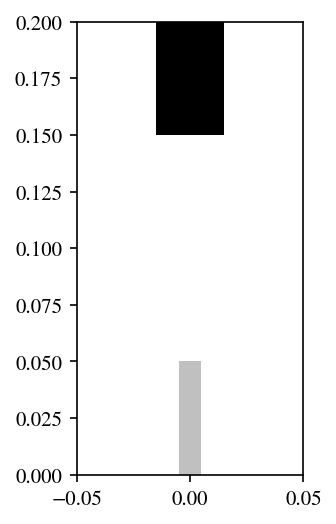

In [23]:
sim = MagLevController()
model = MagLevModel()

end_t=1

k = 855
Kp = k*27
Kd = k*1
Ki=0

# Whether to start magnet off at setpoint or not
warmup = True

sim.runPIDControllerTest(end_t, Kp, Ki, Kd, warmup)
model.runPIDControllerTest(end_t, Kp, Ki, Kd, warmup)

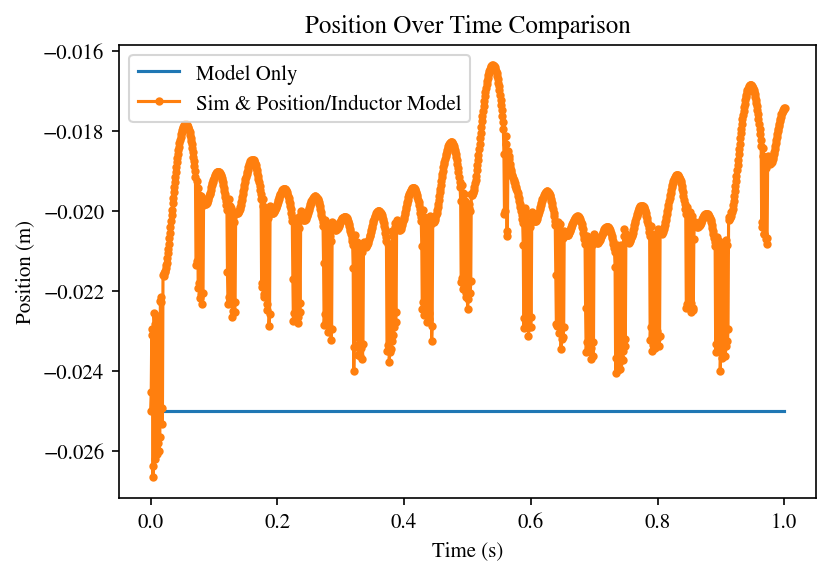

In [24]:
plt.plot(model.ts, -np.array(model.ys[1:]), label='Model Only')
plt.plot(sim.t_list, -np.array(sim.y_list), '.-', label='Sim & Position/Inductor Model')
plt.title("Position Over Time Comparison")
plt.ylabel("Position (m)")
plt.xlabel("Time (s)")
plt.legend()

To see a video of our controller in action, visit: https://photos.app.goo.gl/DcuAdg23ufpoWhGv5